In [1]:
!pip install tqdm pyLDAvis gensim numpy

In [2]:
!conda install -c conda-forge huggingface_hub -y

Solving environment: done

# All requested packages already installed.



In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
import warnings
warnings.filterwarnings("ignore")

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
from quickstart import get_data
service, messages = get_data()

11581918370519256241 1021


In [43]:
print(len(messages))

591


In [53]:
import base64
import re
from tqdm import tqdm
import pandas as pd

def parse_email_digest(content):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    # print(text.encode('utf=8'))
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body
    content = msg['payload']['parts'][0]['body']['data']
    
    # Extract article information for all articles featured in daily digest
    fetched_articles = parse_email_digest(content)
    num_articles_fetched.append(len(fetched_articles))
    for articles in fetched_articles:
        data.append([date, *articles])


100%|██████████| 591/591 [01:35<00:00,  6.16it/s]


In [54]:
print(num_articles_fetched)

[13, 11, 11, 11, 11, 12, 10, 10, 14, 12, 12, 12, 12, 12, 12, 8, 13, 13, 10, 12, 11, 10, 8, 14, 14, 14, 11, 13, 9, 12, 12, 10, 13, 12, 12, 13, 12, 10, 12, 13, 14, 13, 10, 13, 13, 13, 11, 13, 12, 11, 12, 11, 12, 14, 10, 8, 13, 7, 13, 14, 15, 13, 13, 14, 13, 11, 12, 12, 14, 11, 12, 13, 13, 9, 9, 14, 13, 14, 11, 12, 13, 11, 13, 12, 13, 10, 13, 14, 13, 13, 12, 14, 14, 14, 11, 15, 12, 12, 12, 15, 12, 14, 14, 14, 15, 11, 13, 12, 12, 12, 14, 12, 16, 12, 10, 11, 10, 13, 13, 0, 11, 10, 15, 14, 9, 12, 14, 13, 10, 12, 14, 14, 14, 12, 14, 12, 8, 14, 15, 14, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [45]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('article_data_via_gmail_api.csv', index=False)
df

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-11 11:40:00+00:00,Stop One-Hot Encoding your Categorical Feature...,Techniques to Encode Categorical Features with...,Satyam Kumar,The Startup,5
1,2021-08-11 11:40:00+00:00,Encoding Categorical Features,Introduction,Yang Liu,Towards Data Science,6
2,2021-08-11 11:40:00+00:00,How to Write a Headline,Insights from Medium's editorial team,Medium Creators,Creators Hub,5
3,2021-08-11 11:40:00+00:00,Topic Areas to Avoid,The following topics have been covered at leng...,Zack Shapiro,Better Programming,2
4,2021-08-11 11:40:00+00:00,How to Calculate Molecular Similarity,Day 15 of the 66 Days of Data,Chanin Nantasenamat,Data Professor,5
...,...,...,...,...,...,...
1706,2021-03-23 11:10:00+00:00,"Actually, Not a Ton of People Are Moving to Fl...",It turns out it's mostly tech moguls who have ...,Marker Editors,Marker,2
1707,2021-03-23 11:10:00+00:00,Why We Should All Care About the Messy Busines...,Marker readers weigh in on the relevance of st...,Marker Editors,Marker,2
1708,2021-03-23 11:10:00+00:00,Why the Pandemic Is Causing You Motivation Par...,It's time to reset your brain by being nice to it,Allison Hirschlag,The Bold Italic,5
1709,2021-03-23 11:10:00+00:00,The Key to Achieving Your Goals Is Controlled ...,3 strategies for making mistakes you can learn...,Kristin Wong,Forge,5


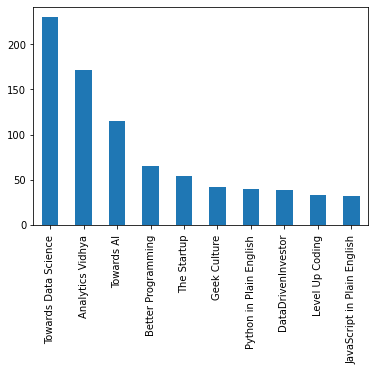

In [9]:
df['Publication'].value_counts().iloc[:10].plot.bar();

## Data Preprocessing

### Lemmatization and Stemming

In [10]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [12]:
doc_sample = df['Title'].iloc[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\ntokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Stop', 'One-Hot', 'Encoding', 'your', 'Categorical', 'Features\u200a-\u200aAvoid', 'Curse', 'of', 'Dimensionality']

tokenized and lemmatized document: 
['stop', 'encod', 'categor', 'featur', 'avoid', 'curs', 'dimension']


In [13]:
df['Titles_combined'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df[['Title', 'Subtitle', 'Titles_combined']].head()

,Title,Subtitle,Titles_combined
0,Stop One-Hot Encoding your Categorical Feature...,Techniques to Encode Categorical Features with...,Stop One-Hot Encoding your Categorical Feature...
1,Encoding Categorical Features,Introduction,Encoding Categorical Features Introduction
2,How to Write a Headline,Insights from Medium's editorial team,How to Write a Headline Insights from Medium's...
3,Topic Areas to Avoid,The following topics have been covered at leng...,Topic Areas to Avoid The following topics have...
4,How to Calculate Molecular Similarity,Day 15 of the 66 Days of Data,How to Calculate Molecular Similarity Day 15 o...


In [14]:
# processed_docs = df['Titles_combined'].map(preprocess)
processed_docs = df['Title'].map(preprocess)
processed_docs[:10]

0    [stop, encod, categor, featur, avoid, curs, di...
1                             [encod, categor, featur]
2                                     [write, headlin]
3                                 [topic, area, avoid]
4                         [calcul, molecular, similar]
5             [storytel, scrollytel, short, introduct]
6                                [introduc, say, titl]
7                        [data, process, plot, python]
8             [make, money, linkedin, secret, societi]
9              [master, data, visual, python, seaborn]
Name: Title, dtype: object

### Bag of Words

In [15]:
dictionary = gensim.corpora.Dictionary(processed_docs)
for k, v in list(dictionary.items())[:10]:
    print(k, v)

0 avoid
1 categor
2 curs
3 dimension
4 encod
5 featur
6 stop
7 headlin
8 write
9 area


In [16]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_doc_1 = bow_corpus[0]

for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                                     dictionary[bow_doc_1[i][0]], 
                                                     bow_doc_1[i][1]))


Word 0 ("featur") appears 1 time.


### TF-IDF

In [17]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
print(corpus_tfidf[0])

[(0, 1.0)]


### Latent Dirichlet Allocation (LDA)

In [18]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)

In [19]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.153*"guid" + 0.077*"import" + 0.075*"learn" + 0.075*"probabl" + 0.067*"effect" + 0.066*"generat" + 0.060*"machin" + 0.038*"python" + 0.031*"algorithm" + 0.030*"explain"
Topic: 1 Word: 0.151*"learn" + 0.066*"tutori" + 0.061*"languag" + 0.059*"want" + 0.043*"linear" + 0.041*"python" + 0.041*"product" + 0.040*"natur" + 0.039*"process" + 0.038*"jupyt"
Topic: 2 Word: 0.327*"work" + 0.054*"learn" + 0.048*"simpl" + 0.037*"deep" + 0.035*"creat" + 0.032*"tutori" + 0.029*"sentiment" + 0.025*"know" + 0.022*"analysi" + 0.022*"model"
Topic: 3 Word: 0.151*"statist" + 0.100*"time" + 0.081*"analysi" + 0.065*"tweet" + 0.057*"librari" + 0.050*"data" + 0.044*"visual" + 0.034*"topic" + 0.033*"python" + 0.029*"model"
Topic: 4 Word: 0.098*"plot" + 0.091*"python" + 0.073*"text" + 0.060*"code" + 0.050*"analysi" + 0.050*"summar" + 0.049*"exampl" + 0.045*"year" + 0.045*"compon" + 0.041*"start"
Topic: 5 Word: 0.244*"python" + 0.159*"data" + 0.066*"scienc" + 0.062*"visual" + 0.059*"word" + 0.059*

In [20]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.149726  0.099664       1        1  9.114328
4      0.120476 -0.134903       2        1  8.408521
10     0.121746  0.025058       3        1  8.027989
12    -0.143779  0.105343       4        1  7.606196
7     -0.094469 -0.027418       5        1  7.571982
13     0.059345  0.190380       6        1  7.116466
1     -0.177688 -0.039840       7        1  6.855025
6     -0.015443 -0.106143       8        1  6.412862
8      0.061050 -0.088699       9        1  6.210597
3      0.053192 -0.013573      10        1  6.112358
9      0.115023  0.074546      11        1  6.085399
11     0.073316 -0.078201      12        1  5.797874
14    -0.125719  0.027683      13        1  5.428412
0     -0.129294  0.075904      14        1  5.399006
2     -0.067482 -0.109801      15        1  3.852985, topic_info=       Term       Freq       Total Category  logprob  loglift
77     work  28.000000   28.000000  Default  30.0000  30.0000
11   scienc  51.000000   51.000000  Default  29.0000  29.0000
20   machin  50.000000   50.000000  Default  28.0000  28.0000
78    react  21.000000   21.000000  Default  27.0000  27.0000
41  statist  22.000000   22.000000  Default  26.0000  26.0000
..      ...        ...         ...      ...      ...      ...
73    chang   0.357457   15.034075  Topic15  -5.3171  -0.4827
0    featur   0.451574   21.186937  Topic15  -5.0834  -0.5921
7    python   1.169574  115.092008  Topic15  -4.1317  -1.3328
4      data   0.865399   94.479297  Topic15  -4.4329  -1.4366
20   machin   0.540193   50.895926  Topic15  -4.9042  -1.2893

[537 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
22        2  0.077943  algorithm
22        5  0.077943  algorithm
22        6  0.545601  algorithm
22        7  0.038972  algorithm
22        9  0.038972  algorithm
...     ...       ...        ...
38        4  0.069875       year
38        8  0.069875       year
38        9  0.139750       year
38       11  0.139750       year
38       15  0.069875       year

[529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 11, 13, 8, 14, 2, 7, 9, 4, 10, 12, 15, 1, 3])

### BERTopic

In [21]:
df.head()

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Title,Subtitle,Author,Publication,Minutes,Titles_combined
0,2021-08-11,Stop One-Hot Encoding your Categorical Feature...,Techniques to Encode Categorical Features with...,Satyam Kumar,The Startup,5,Stop One-Hot Encoding your Categorical Feature...
1,2021-08-11,Encoding Categorical Features,Introduction,Yang Liu,Towards Data Science,6,Encoding Categorical Features Introduction
2,2021-08-11,How to Write a Headline,Insights from Medium's editorial team,Medium Creators,Creators Hub,5,How to Write a Headline Insights from Medium's...
3,2021-08-11,Topic Areas to Avoid,The following topics have been covered at leng...,Zack Shapiro,Better Programming,2,Topic Areas to Avoid The following topics have...
4,2021-08-11,How to Calculate Molecular Similarity,Day 15 of the 66 Days of Data,Chanin Nantasenamat,Data Professor,5,How to Calculate Molecular Similarity Day 15 o...


In [22]:
!conda install -c conda-forge hdbscan -y

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Solving environment: done

# All requested packages already installed.



In [29]:
!pip install bertopic

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
from bertopic import BERTopic

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ImportError: cannot import name '_BaseLazyModule' from 'transformers.file_utils' (/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/transformers/file_utils.py)

In [ ]:
titles = df.Title.to_list()

In [ ]:
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(titles)

In [ ]:
dates = df['Date'].apply(lambda x: pd.Timestamp(x))
topics_over_time = topic_model.topics_over_time(titles, topics, dates, nr_bins=20)


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time)